In [1]:
!pip3 install bayesian-optimization==0.6 --user

You are using pip version 18.1, however version 19.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


I use `bayesian-optimization==0.6`, my backend pretty much stick with this version, so migrating will break the code.

In [2]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import seaborn as sns
import random
from bayes_opt import BayesianOptimization
sns.set()

In [3]:
import pkg_resources
import types


def get_imports():
    for name, val in globals().items():
        if isinstance(val, types.ModuleType):
            name = val.__name__.split('.')[0]
        elif isinstance(val, type):
            name = val.__module__.split('.')[0]
        poorly_named_packages = {'PIL': 'Pillow', 'sklearn': 'scikit-learn'}
        if name in poorly_named_packages.keys():
            name = poorly_named_packages[name]
        yield name


imports = list(set(get_imports()))
requirements = []
for m in pkg_resources.working_set:
    if m.project_name in imports and m.project_name != 'pip':
        requirements.append((m.project_name, m.version))

for r in requirements:
    print('{}=={}'.format(*r))

seaborn==0.9.0
pandas==0.23.4
numpy==1.14.5
matplotlib==3.0.2


In [4]:
def get_state(data, t, n):
    d = t - n + 1
    block = data[d : t + 1] if d >= 0 else -d * [data[0]] + data[0 : t + 1]
    res = []
    for i in range(n - 1):
        res.append(block[i + 1] - block[i])
    return np.array([res])

TSLA Time Period: **Mar 23, 2018 - Mar 23, 2019**

In [5]:
df = pd.read_csv('../dataset/TSLA.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-03-23,311.250000,311.250000,300.450012,301.540009,301.540009,6654900
1,2018-03-26,307.339996,307.589996,291.359985,304.179993,304.179993,8375200
2,2018-03-27,304.000000,304.269989,277.179993,279.179993,279.179993,13872000
3,2018-03-28,264.579987,268.679993,252.100006,257.779999,257.779999,21001400
4,2018-03-29,256.489990,270.959991,248.210007,266.130005,266.130005,15170700


In [6]:
close = df.Close.values.tolist()
window_size = 30
skip = 5
l = len(close) - 1

In [7]:
class Deep_Evolution_Strategy:

    inputs = None

    def __init__(
        self, weights, reward_function, population_size, sigma, learning_rate
    ):
        self.weights = weights
        self.reward_function = reward_function
        self.population_size = population_size
        self.sigma = sigma
        self.learning_rate = learning_rate

    def _get_weight_from_population(self, weights, population):
        weights_population = []
        for index, i in enumerate(population):
            jittered = self.sigma * i
            weights_population.append(weights[index] + jittered)
        return weights_population

    def get_weights(self):
        return self.weights

    def train(self, epoch = 100, print_every = 1):
        lasttime = time.time()
        for i in range(epoch):
            population = []
            rewards = np.zeros(self.population_size)
            for k in range(self.population_size):
                x = []
                for w in self.weights:
                    x.append(np.random.randn(*w.shape))
                population.append(x)
            for k in range(self.population_size):
                weights_population = self._get_weight_from_population(
                    self.weights, population[k]
                )
                rewards[k] = self.reward_function(weights_population)
            rewards = (rewards - np.mean(rewards)) / np.std(rewards)
            for index, w in enumerate(self.weights):
                A = np.array([p[index] for p in population])
                self.weights[index] = (
                    w
                    + self.learning_rate
                    / (self.population_size * self.sigma)
                    * np.dot(A.T, rewards).T
                )
            if (i + 1) % print_every == 0:
                print(
                    'iter %d. reward: %f'
                    % (i + 1, self.reward_function(self.weights))
                )
        print('time taken to train:', time.time() - lasttime, 'seconds')


class Model:
    def __init__(self, input_size, layer_size, output_size):
        self.weights = [
            np.random.randn(input_size, layer_size),
            np.random.randn(layer_size, output_size),
            np.random.randn(layer_size, 1),
            np.random.randn(1, layer_size),
        ]

    def predict(self, inputs):
        feed = np.dot(inputs, self.weights[0]) + self.weights[-1]
        decision = np.dot(feed, self.weights[1])
        buy = np.dot(feed, self.weights[2])
        return decision, buy

    def get_weights(self):
        return self.weights

    def set_weights(self, weights):
        self.weights = weights

In [8]:
class Agent:
    def __init__(
        self,
        population_size,
        sigma,
        learning_rate,
        model,
        money,
        max_buy,
        max_sell,
        skip,
        window_size,
    ):
        self.window_size = window_size
        self.skip = skip
        self.POPULATION_SIZE = population_size
        self.SIGMA = sigma
        self.LEARNING_RATE = learning_rate
        self.model = model
        self.initial_money = money
        self.max_buy = max_buy
        self.max_sell = max_sell
        self.es = Deep_Evolution_Strategy(
            self.model.get_weights(),
            self.get_reward,
            self.POPULATION_SIZE,
            self.SIGMA,
            self.LEARNING_RATE,
        )

    def act(self, sequence):
        decision, buy = self.model.predict(np.array(sequence))
        return np.argmax(decision[0]), int(buy[0])

    def get_reward(self, weights):
        initial_money = self.initial_money
        starting_money = initial_money
        self.model.weights = weights
        state = get_state(close, 0, self.window_size + 1)
        inventory = []
        quantity = 0
        for t in range(0, l, self.skip):
            action, buy = self.act(state)
            next_state = get_state(close, t + 1, self.window_size + 1)
            if action == 1 and initial_money >= close[t]:
                if buy < 0:
                    buy = 1
                if buy > self.max_buy:
                    buy_units = self.max_buy
                else:
                    buy_units = buy
                total_buy = buy_units * close[t]
                initial_money -= total_buy
                inventory.append(total_buy)
                quantity += buy_units
            elif action == 2 and len(inventory) > 0:
                if quantity > self.max_sell:
                    sell_units = self.max_sell
                else:
                    sell_units = quantity
                quantity -= sell_units
                total_sell = sell_units * close[t]
                initial_money += total_sell

            state = next_state
        return ((initial_money - starting_money) / starting_money) * 100

    def fit(self, iterations, checkpoint):
        self.es.train(iterations, print_every = checkpoint)

    def buy(self):
        initial_money = self.initial_money
        state = get_state(close, 0, self.window_size + 1)
        starting_money = initial_money
        states_sell = []
        states_buy = []
        inventory = []
        quantity = 0
        for t in range(0, l, self.skip):
            action, buy = self.act(state)
            next_state = get_state(close, t + 1, self.window_size + 1)
            if action == 1 and initial_money >= close[t]:
                if buy < 0:
                    buy = 1
                if buy > self.max_buy:
                    buy_units = self.max_buy
                else:
                    buy_units = buy
                total_buy = buy_units * close[t]
                initial_money -= total_buy
                inventory.append(total_buy)
                quantity += buy_units
                states_buy.append(t)
                print(
                    'day %d: buy %d units at price %f, total balance %f'
                    % (t, buy_units, total_buy, initial_money)
                )
            elif action == 2 and len(inventory) > 0:
                bought_price = inventory.pop(0)
                if quantity > self.max_sell:
                    sell_units = self.max_sell
                else:
                    sell_units = quantity
                if sell_units < 1:
                    continue
                quantity -= sell_units
                total_sell = sell_units * close[t]
                initial_money += total_sell
                states_sell.append(t)
                try:
                    invest = ((total_sell - bought_price) / bought_price) * 100
                except:
                    invest = 0
                print(
                    'day %d, sell %d units at price %f, investment %f %%, total balance %f,'
                    % (t, sell_units, total_sell, invest, initial_money)
                )
            state = next_state

        invest = ((initial_money - starting_money) / starting_money) * 100
        print(
            '\ntotal gained %f, total investment %f %%'
            % (initial_money - starting_money, invest)
        )
        plt.figure(figsize = (20, 10))
        plt.plot(close, label = 'true close', c = 'g')
        plt.plot(
            close, 'X', label = 'predict buy', markevery = states_buy, c = 'b'
        )
        plt.plot(
            close, 'o', label = 'predict sell', markevery = states_sell, c = 'r'
        )
        plt.legend()
        plt.show()

In [9]:
def best_agent(
    window_size, skip, population_size, sigma, learning_rate, size_network
):
    model = Model(window_size, size_network, 3)
    agent = Agent(
        population_size,
        sigma,
        learning_rate,
        model,
        10000,
        5,
        5,
        skip,
        window_size,
    )
    try:
        agent.fit(100, 1000)
        return agent.es.reward_function(agent.es.weights)
    except:
        return 0

In [10]:
def find_best_agent(
    window_size, skip, population_size, sigma, learning_rate, size_network
):
    global accbest
    param = {
        'window_size': int(np.around(window_size)),
        'skip': int(np.around(skip)),
        'population_size': int(np.around(population_size)),
        'sigma': max(min(sigma, 1), 0.0001),
        'learning_rate': max(min(learning_rate, 0.5), 0.000001),
        'size_network': int(np.around(size_network)),
    }
    print('\nSearch parameters %s' % (param))
    investment = best_agent(**param)
    print('stop after 100 iteration with investment %f' % (investment))
    if investment > accbest:
        costbest = investment
    return investment

In [11]:
accbest = 0.0
NN_BAYESIAN = BayesianOptimization(
    find_best_agent,
    {
        'window_size': (2, 50),
        'skip': (1, 15),
        'population_size': (1, 50),
        'sigma': (0.01, 0.99),
        'learning_rate': (0.000001, 0.49),
        'size_network': (10, 1000),
    },
)
NN_BAYESIAN.maximize(init_points = 30, n_iter = 50, acq = 'ei', xi = 0.0)

Initialization
----------------------------------------------------------------------------------------------------------------------------
 Step |   Time |      Value |   learning_rate |   population_size |     sigma |   size_network |      skip |   window_size | 

Search parameters {'window_size': 32, 'skip': 4, 'population_size': 14, 'sigma': 0.6924932742559208, 'learning_rate': 0.4506746405913942, 'size_network': 903}
time taken to train: 3.6314964294433594 seconds
stop after 100 iteration with investment 45.469898
    1 | 00m03s |   45.46990 |          0.4507 |           14.1205 |    0.6925 |       903.2810 |    3.8596 |       32.0389 | 

Search parameters {'window_size': 9, 'skip': 2, 'population_size': 40, 'sigma': 0.6314318303690627, 'learning_rate': 0.2665435889829382, 'size_network': 418}
time taken to train: 6.387232542037964 seconds
stop after 100 iteration with investment 46.435302
    2 | 00m06s |   46.43530 |          0.2665 |           40.1437 |    0.6314 |       417.62

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


time taken to train: 3.6136224269866943 seconds
stop after 100 iteration with investment 20.886098
    4 | 00m03s |   20.88610 |          0.2756 |           16.9868 |    0.9721 |       776.5696 |    2.8687 |       19.7415 | 

Search parameters {'window_size': 10, 'skip': 10, 'population_size': 12, 'sigma': 0.9587684522335657, 'learning_rate': 0.3107466445720601, 'size_network': 196}
time taken to train: 0.47393083572387695 seconds
stop after 100 iteration with investment 15.384199
    5 | 00m00s |   15.38420 |          0.3107 |           12.0360 |    0.9588 |       196.2702 |   10.3654 |        9.5100 | 

Search parameters {'window_size': 16, 'skip': 15, 'population_size': 16, 'sigma': 0.9424607807175174, 'learning_rate': 0.4304065851197905, 'size_network': 101}
time taken to train: 0.4492471218109131 seconds
stop after 100 iteration with investment 10.937500
    6 | 00m00s |   10.93750 |          0.4304 |           15.7218 |    0.9425 |       101.4025 |   14.7170 |       16.4290 | 

S

time taken to train: 10.965286254882812 seconds
stop after 100 iteration with investment 54.670205
   26 | 00m10s |   54.67021 |          0.4238 |           40.6576 |    0.3113 |       614.1548 |    2.5591 |       37.7406 | 

Search parameters {'window_size': 38, 'skip': 1, 'population_size': 34, 'sigma': 0.33251817501018216, 'learning_rate': 0.28025378213533453, 'size_network': 601}
time taken to train: 19.4577956199646 seconds
stop after 100 iteration with investment 90.161499
   27 | 00m19s |   90.16150 |          0.2803 |           34.1475 |    0.3325 |       600.7703 |    1.2320 |       37.7156 | 

Search parameters {'window_size': 23, 'skip': 2, 'population_size': 15, 'sigma': 0.25337476478163296, 'learning_rate': 0.4721917822578962, 'size_network': 777}
time taken to train: 4.5063018798828125 seconds
stop after 100 iteration with investment 35.491501
   28 | 00m04s |   35.49150 |          0.4722 |           15.0837 |    0.2534 |       777.1621 |    2.1678 |       22.5169 | 

Sea

time taken to train: 10.297287225723267 seconds
stop after 100 iteration with investment 24.141198
   47 | 00m11s |   24.14120 |          0.4559 |           40.3615 |    0.6965 |       900.4400 |    8.2389 |       45.1515 | 

Search parameters {'window_size': 18, 'skip': 14, 'population_size': 2, 'sigma': 0.04039851162238903, 'learning_rate': 0.22501631948214842, 'size_network': 723}
stop after 100 iteration with investment 0.000000
   48 | 00m01s |    0.00000 |          0.2250 |            2.2811 |    0.0404 |       723.0895 |   13.6784 |       18.3855 | 

Search parameters {'window_size': 31, 'skip': 8, 'population_size': 14, 'sigma': 0.454631410056508, 'learning_rate': 0.24625843061415703, 'size_network': 74}
time taken to train: 0.7722418308258057 seconds
stop after 100 iteration with investment 18.272197
   49 | 00m02s |   18.27220 |          0.2463 |           14.1262 |    0.4546 |        74.3288 |    7.5932 |       30.7744 | 

Search parameters {'window_size': 15, 'skip': 6, 'po

stop after 100 iteration with investment 0.000000
   69 | 00m02s |    0.00000 |          0.3887 |           11.7058 |    0.3525 |       174.7174 |   12.9577 |        8.5275 | 

Search parameters {'window_size': 5, 'skip': 12, 'population_size': 6, 'sigma': 0.8007659832230785, 'learning_rate': 0.27630041062284755, 'size_network': 154}
time taken to train: 0.17244505882263184 seconds
stop after 100 iteration with investment 6.806999
   70 | 00m01s |    6.80700 |          0.2763 |            5.7301 |    0.8008 |       154.3186 |   12.0720 |        4.5087 | 

Search parameters {'window_size': 11, 'skip': 10, 'population_size': 37, 'sigma': 0.05355815832861388, 'learning_rate': 0.2366377480881774, 'size_network': 303}
stop after 100 iteration with investment 0.000000
   71 | 00m02s |    0.00000 |          0.2366 |           37.4679 |    0.0536 |       302.7305 |    9.5728 |       10.6437 | 

Search parameters {'window_size': 10, 'skip': 4, 'population_size': 7, 'sigma': 0.08748548532444651,

In [12]:
print('Best AGENT accuracy value: %f' % NN_BAYESIAN.res['max']['max_val'])
print('Best AGENT parameters: ', NN_BAYESIAN.res['max']['max_params'])

Best AGENT accuracy value: 118.454998
Best AGENT parameters:  {'window_size': 37.026745406700485, 'skip': 1.398295139557024, 'population_size': 33.375200286661, 'sigma': 0.36295005827770077, 'learning_rate': 0.47908981350049923, 'size_network': 601.8917542486957}


#### My selected parameters

In [13]:
best_agent(
    window_size = 30, 
    skip = 1, 
    population_size = 15, 
    sigma = 0.1, 
    learning_rate = 0.03, 
    size_network = 500
)

time taken to train: 7.432262897491455 seconds


60.71330993000004

#### bayesian parameters

In [14]:
best_agent(
    window_size = int(np.around(NN_BAYESIAN.res['max']['max_params']['window_size'])), 
    skip = int(np.around(NN_BAYESIAN.res['max']['max_params']['skip'])), 
    population_size = int(np.around(NN_BAYESIAN.res['max']['max_params']['population_size'])), 
    sigma = NN_BAYESIAN.res['max']['max_params']['sigma'], 
    learning_rate = NN_BAYESIAN.res['max']['max_params']['learning_rate'], 
    size_network = int(np.around(NN_BAYESIAN.res['max']['max_params']['size_network']))
)

time taken to train: 18.46750020980835 seconds


105.43940030999998

#### My selected parameters

iter 100. reward: 78.018904
iter 200. reward: 104.486503
iter 300. reward: 111.254201
iter 400. reward: 112.303196
iter 500. reward: 117.427600
time taken to train: 35.953824043273926 seconds
day 2: buy 5 units at price 1395.899965, total balance 8604.100035
day 3: buy 5 units at price 1288.899995, total balance 7315.200040
day 4: buy 5 units at price 1330.650025, total balance 5984.550015
day 5: buy 5 units at price 1262.399980, total balance 4722.150035
day 6: buy 1 units at price 267.529999, total balance 4454.620036
day 8, sell 5 units at price 1528.600005, investment 9.506415 %, total balance 5983.220041,
day 11, sell 5 units at price 1523.500060, investment 18.201572 %, total balance 7506.720101,
day 12, sell 5 units at price 1504.649965, investment 13.076311 %, total balance 9011.370066,
day 14, sell 5 units at price 1501.699980, investment 18.955957 %, total balance 10513.070046,
day 15, sell 1 units at price 291.209991, investment 8.851341 %, total balance 10804.280037,
day 16

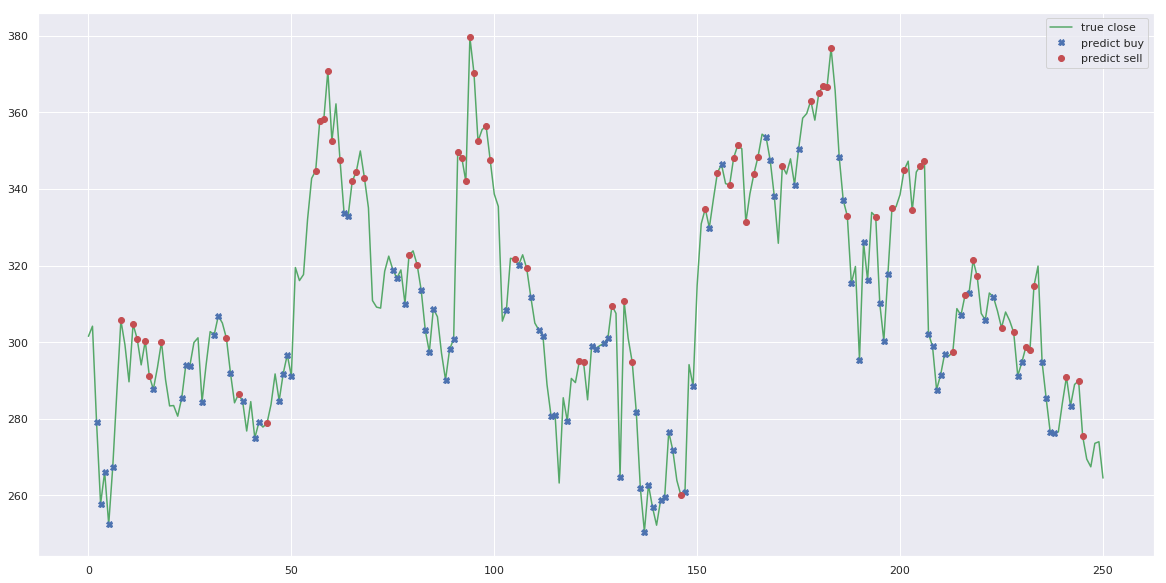

In [18]:
model = Model(input_size = 30, 
              layer_size = 500, 
              output_size = 3)
agent = Agent(population_size = 15, 
              sigma = 0.1, 
              learning_rate = 0.03, 
              model = model, 
              money = 10000, 
              max_buy = 5, 
              max_sell = 5, 
              skip = 1, 
              window_size = 30)
agent.fit(500, 100)
agent.buy()

#### bayesian parameters

iter 100. reward: 115.522302
iter 200. reward: 122.923396
iter 300. reward: 128.013799
iter 400. reward: 129.764900
iter 500. reward: 133.173699
time taken to train: 93.03121662139893 seconds
day 2: buy 5 units at price 1395.899965, total balance 8604.100035
day 3: buy 5 units at price 1288.899995, total balance 7315.200040
day 4: buy 5 units at price 1330.650025, total balance 5984.550015
day 5: buy 5 units at price 1262.399980, total balance 4722.150035
day 6: buy 5 units at price 1337.649995, total balance 3384.500040
day 7: buy 5 units at price 1434.700010, total balance 1949.800030
day 11, sell 5 units at price 1523.500060, investment 9.141063 %, total balance 3473.300090,
day 12: buy 1 units at price 300.929993, total balance 3172.370097
day 13, sell 5 units at price 1470.399935, investment 14.081771 %, total balance 4642.770032,
day 14, sell 5 units at price 1501.699980, investment 12.854616 %, total balance 6144.470012,
day 15, sell 5 units at price 1456.049955, investment 15.3

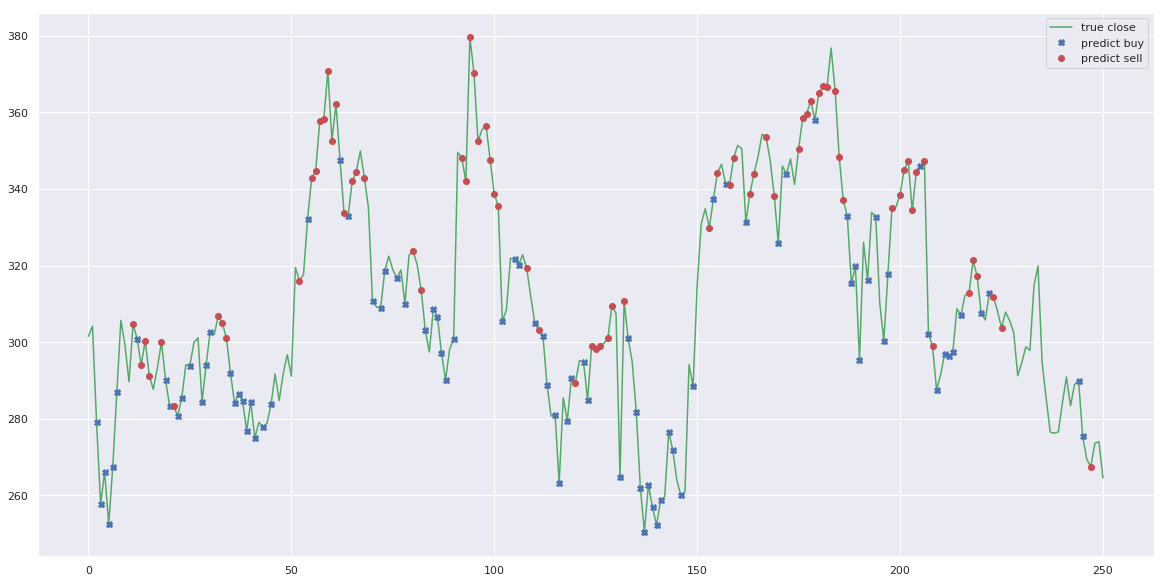

In [19]:
model = Model(input_size = int(np.around(NN_BAYESIAN.res['max']['max_params']['window_size'])), 
              layer_size = int(np.around(NN_BAYESIAN.res['max']['max_params']['size_network'])), 
              output_size = 3)
agent = Agent(population_size = int(np.around(NN_BAYESIAN.res['max']['max_params']['population_size'])), 
              sigma = NN_BAYESIAN.res['max']['max_params']['sigma'], 
              learning_rate = NN_BAYESIAN.res['max']['max_params']['learning_rate'], 
              model = model, 
              money = 10000, 
              max_buy = 5, 
              max_sell = 5, 
              skip = int(np.around(NN_BAYESIAN.res['max']['max_params']['skip'])), 
              window_size = int(np.around(NN_BAYESIAN.res['max']['max_params']['window_size'])))
agent.fit(500, 100)
agent.buy()